# Курсовая работа (Семестр 2)
## Выполнил: Авакян Александр, группа: М8О-114СВ-24
### Датасет (Muffin vs chihuahua)
Это задача бинарной классификации изображений, в которой используется около 6000 изображений, взятых из Google Images. Дублирующиеся изображения были удалены. Содержит два типа изображений - кексы и чихуахуа

Подключим библиотеки

In [1]:
import os
import glob
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torchvision
import torch.optim as optim

from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

Загрузим датасет - укажем тренировочную и тестовую выборки

In [2]:
train_path = os.path.join(os.getcwd(), "train")
test_path = os.path.join(os.getcwd(), "test")

Выведем тренировочные и тестовые выборки

In [3]:
def display_images(folder_path, num_images=10):
    classes = os.listdir(folder_path)
    image_paths = [glob.glob(f"{os.path.join(folder_path, clas)}/*.jpg") for clas in classes]
    image_paths_full = list(itertools.chain(image_paths[0], image_paths[1]))

    selected = random.sample(image_paths_full, num_images)

    fig, axs = plt.subplots(2, 5, figsize=(15, 6))

    for i, img_path in enumerate(selected):
        img = Image.open(img_path)
        ax = axs[i // 5, i % 5]
        ax.imshow(img)
        # Handle both Windows and Unix paths
        class_name = os.path.normpath(img_path).split(os.sep)[-2]
        ax.set_title(class_name)
        ax.axis('off')
    plt.show()

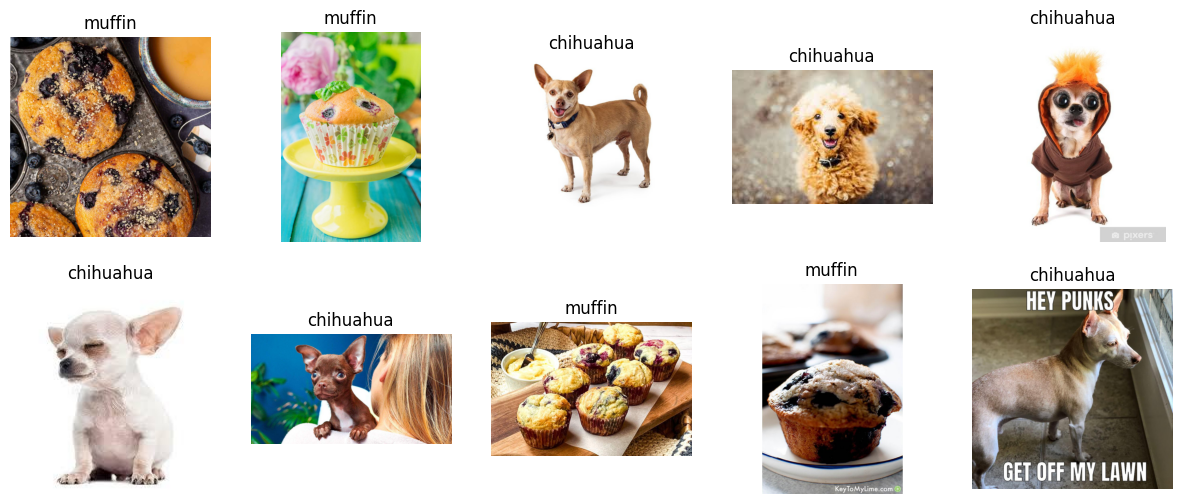

In [4]:
display_images(train_path)

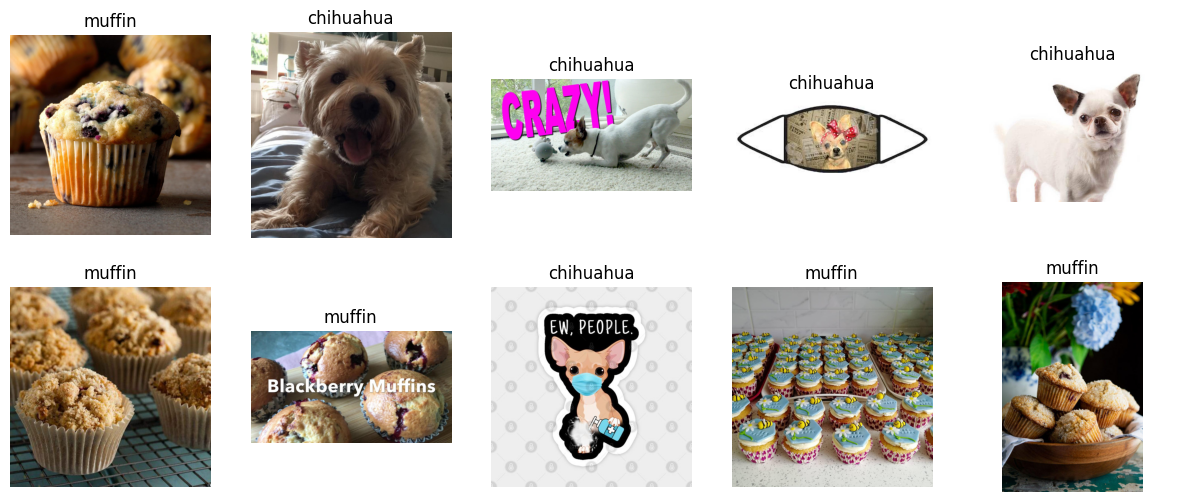

In [7]:
display_images(test_path)

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.1),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
train_ds = torchvision.datasets.ImageFolder(train_path, transform=train_transform)
test_ds = torchvision.datasets.ImageFolder(test_path, transform=test_transform)
train_ds, test_ds

(Dataset ImageFolder
     Number of datapoints: 4733
     Root location: c:\Users\Alexs\Desktop\Магистратура 2 курс\ML\Course_work\train
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-0.1, 0.1], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 1184
     Root location: c:\Users\Alexs\Desktop\Магистратура 2 курс\ML\Course_work\test
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 

In [10]:
train_dataloader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=32)

Используем предобученную модель densenet121

In [11]:
model = models.densenet121(weights='DEFAULT')


In [12]:
for param in model.parameters():
    param.requires_grad = False

In [13]:
model.classifier = nn.Linear(model.classifier.in_features, len(train_ds.classes))
model.classifier

Linear(in_features=1024, out_features=2, bias=True)

In [14]:
for param in model.classifier.parameters():
    param.requires_grad = True

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [16]:
model = model.to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

In [18]:
def train_one_epoch(model, train_dataloader, criterion, optimizer):
    model.train()

    total_loss = 0
    for images, labels in tqdm(train_dataloader):

        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss

def test(model, test_dataloader, criterion):
    model.eval()

    with torch.no_grad():

        total_loss = 0
        correct = 0

        for images, labels in tqdm(test_dataloader):

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / len(test_dataloader.dataset)
        avg_loss = total_loss / len(test_dataloader)

    return avg_loss, accuracy

In [19]:
def train(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=10):

    for epoch in range(num_epochs):

        train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer)
        test_loss, accuracy = test(model, test_dataloader, criterion)

        print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Accuracy:{accuracy:.2f}%')

In [20]:
train(model, train_dataloader, test_dataloader, criterion, optimizer, 10)

100%|██████████| 37/37 [00:48<00:00,  1.30s/it]


Epoch: 1/10 | Train Loss: 0.4169 | Test Loss: 0.2449 | Accuracy:97.47%


100%|██████████| 37/37 [00:37<00:00,  1.01s/it]


Epoch: 2/10 | Train Loss: 0.1953 | Test Loss: 0.1371 | Accuracy:97.97%


100%|██████████| 37/37 [00:48<00:00,  1.30s/it]


Epoch: 3/10 | Train Loss: 0.1356 | Test Loss: 0.1019 | Accuracy:98.40%


100%|██████████| 37/37 [00:40<00:00,  1.11s/it]


Epoch: 4/10 | Train Loss: 0.1055 | Test Loss: 0.0809 | Accuracy:98.40%


100%|██████████| 37/37 [00:48<00:00,  1.32s/it]


Epoch: 5/10 | Train Loss: 0.0897 | Test Loss: 0.0664 | Accuracy:98.56%


100%|██████████| 37/37 [00:48<00:00,  1.32s/it]


Epoch: 6/10 | Train Loss: 0.0764 | Test Loss: 0.0588 | Accuracy:98.73%


100%|██████████| 37/37 [00:49<00:00,  1.33s/it]


Epoch: 7/10 | Train Loss: 0.0729 | Test Loss: 0.0529 | Accuracy:98.56%


100%|██████████| 37/37 [00:43<00:00,  1.17s/it]


Epoch: 8/10 | Train Loss: 0.0624 | Test Loss: 0.0464 | Accuracy:98.73%


100%|██████████| 37/37 [00:47<00:00,  1.28s/it]


Epoch: 9/10 | Train Loss: 0.0588 | Test Loss: 0.0438 | Accuracy:98.99%


100%|██████████| 37/37 [00:45<00:00,  1.23s/it]

Epoch: 10/10 | Train Loss: 0.0584 | Test Loss: 0.0440 | Accuracy:99.07%


Проверим корректность распознавания. 
0 - чихуахуа
1 - кекс

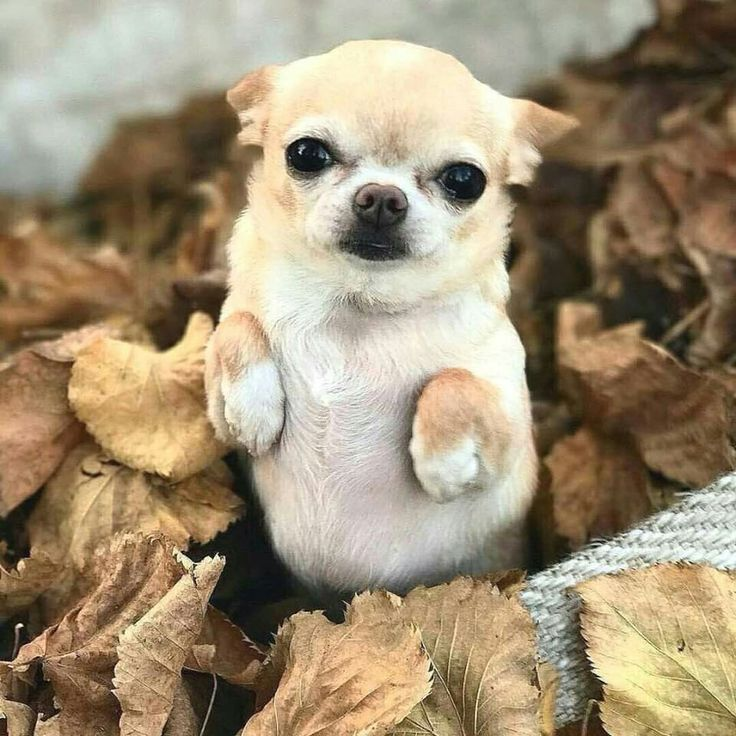

In [186]:
img_example = img_path = os.path.join(os.getcwd(), "example", "example1.jpg")
img = Image.open(img_example)
img

In [187]:
img = test_transform(img)

In [188]:
output = model(img.unsqueeze(0).to(device))
torch.argmax(output).item()

0

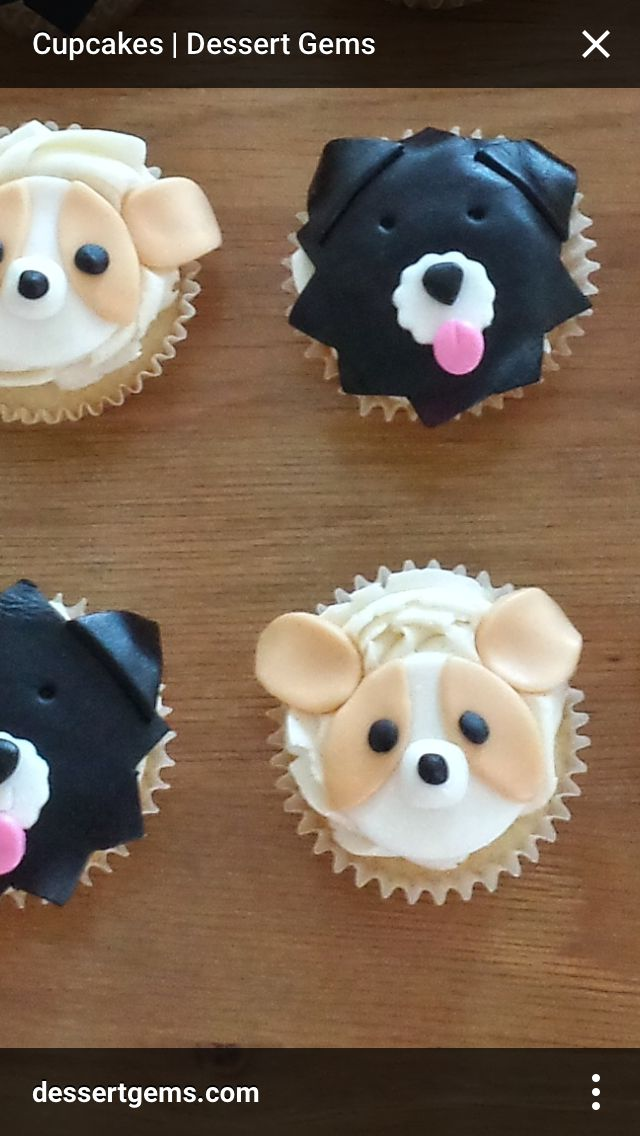

In [189]:
img_example = img_path = os.path.join(os.getcwd(), "example", "example2.jpg")
img = Image.open(img_example)
img

In [190]:
img = test_transform(img)
output = model(img.unsqueeze(0).to(device))
torch.argmax(output).item()

1

Используя LIME выделим признаки классификации

100%|██████████| 1000/1000 [00:36<00:00, 27.49it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3262744].


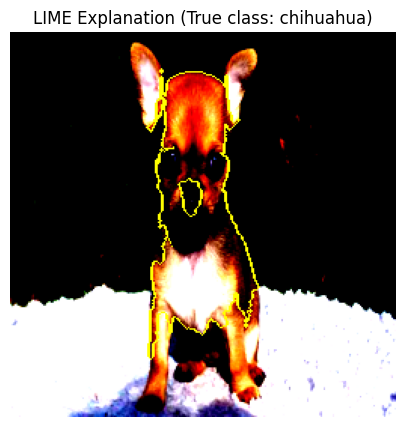

In [ ]:
import lime
from lime import lime_image
import shap
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

def get_test_image():
    random_idx = random.randint(0, len(test_ds)-1)
    image, label = test_ds[random_idx]
    return image.unsqueeze(0).to(device), label, random_idx

test_image, true_label, idx = get_test_image()

model_cpu = model.to('cpu')
test_image_cpu = test_image.to('cpu')


def lime_explanation(image, model, top_labels=5, hide_color=0, num_samples=1000):
    
    def batch_predict(images):
        model.eval()
        batch = torch.stack([
            transforms.functional.to_tensor(img) for img in images
        ]).float()
        batch = transforms.functional.normalize(
            batch, 
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
        device = next(model.parameters()).device
        batch = batch.to(device)
        
        with torch.no_grad():
            logits = model(batch)
            probs = torch.nn.functional.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()
    
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image[0].permute(1, 2, 0).cpu().numpy(), 
        batch_predict,
        top_labels=top_labels, 
        hide_color=hide_color, 
        num_samples=num_samples
    )
    return explanation

test_image, true_label, idx = get_test_image()
test_image_cpu = test_image.cpu()

lime_exp = lime_explanation(test_image_cpu, model.to('cpu'))

plt.figure(figsize=(10, 5))
temp, mask = lime_exp.get_image_and_mask(
    lime_exp.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=False
)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f'LIME Explanation (True class: {test_ds.classes[true_label]})')
plt.axis('off')
plt.show()

c:\Users\Alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [00:37<00:00, 26.86it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.622571].


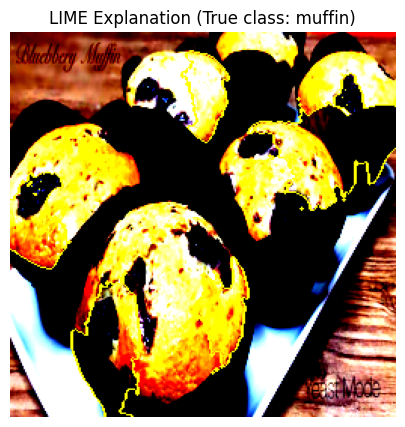

In [21]:
import lime
from lime import lime_image
import shap
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

def get_test_image():
    random_idx = random.randint(0, len(test_ds)-1)
    image, label = test_ds[random_idx]
    return image.unsqueeze(0).to(device), label, random_idx

test_image, true_label, idx = get_test_image()

model_cpu = model.to('cpu')
test_image_cpu = test_image.to('cpu')


def lime_explanation(image, model, top_labels=5, hide_color=0, num_samples=1000):
    
    def batch_predict(images):
        model.eval()
        batch = torch.stack([
            transforms.functional.to_tensor(img) for img in images
        ]).float()
        batch = transforms.functional.normalize(
            batch, 
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
        device = next(model.parameters()).device
        batch = batch.to(device)
        
        with torch.no_grad():
            logits = model(batch)
            probs = torch.nn.functional.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()
    
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image[0].permute(1, 2, 0).cpu().numpy(), 
        batch_predict,
        top_labels=top_labels, 
        hide_color=hide_color, 
        num_samples=num_samples
    )
    return explanation

test_image, true_label, idx = get_test_image()
test_image_cpu = test_image.cpu()

lime_exp = lime_explanation(test_image_cpu, model.to('cpu'))

plt.figure(figsize=(10, 5))
temp, mask = lime_exp.get_image_and_mask(
    lime_exp.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=False
)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f'LIME Explanation (True class: {test_ds.classes[true_label]})')
plt.axis('off')
plt.show()

100%|██████████| 1000/1000 [00:39<00:00, 25.64it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.622571].


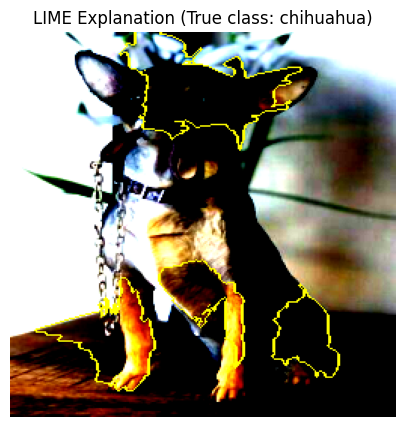

In [22]:
test_image, true_label, idx = get_test_image()
test_image_cpu = test_image.cpu()

lime_exp = lime_explanation(test_image_cpu, model.to('cpu'))

plt.figure(figsize=(10, 5))
temp, mask = lime_exp.get_image_and_mask(
    lime_exp.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=False
)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f'LIME Explanation (True class: {test_ds.classes[true_label]})')
plt.axis('off')
plt.show()

100%|██████████| 1000/1000 [00:36<00:00, 27.62it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


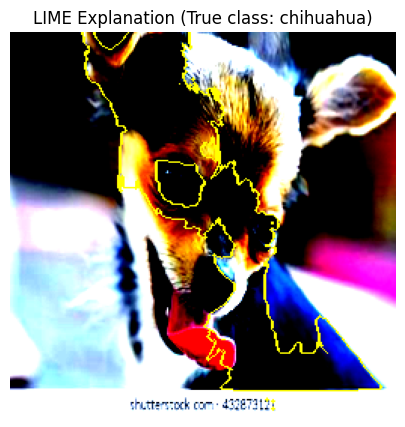

In [23]:
test_image, true_label, idx = get_test_image()
test_image_cpu = test_image.cpu()

lime_exp = lime_explanation(test_image_cpu, model.to('cpu'))

plt.figure(figsize=(10, 5))
temp, mask = lime_exp.get_image_and_mask(
    lime_exp.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=False
)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f'LIME Explanation (True class: {test_ds.classes[true_label]})')
plt.axis('off')
plt.show()

100%|██████████| 1000/1000 [00:38<00:00, 26.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


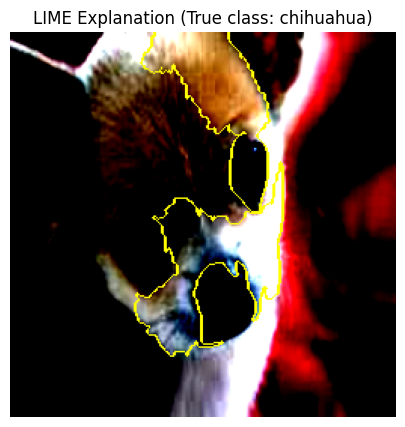

In [24]:
test_image, true_label, idx = get_test_image()
test_image_cpu = test_image.cpu()

lime_exp = lime_explanation(test_image_cpu, model.to('cpu'))

plt.figure(figsize=(10, 5))
temp, mask = lime_exp.get_image_and_mask(
    lime_exp.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=False
)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f'LIME Explanation (True class: {test_ds.classes[true_label]})')
plt.axis('off')
plt.show()

100%|██████████| 1000/1000 [00:33<00:00, 29.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.6051416].


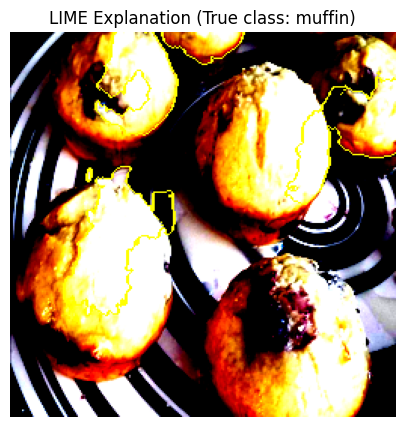

In [25]:
test_image, true_label, idx = get_test_image()
test_image_cpu = test_image.cpu()

lime_exp = lime_explanation(test_image_cpu, model.to('cpu'))

plt.figure(figsize=(10, 5))
temp, mask = lime_exp.get_image_and_mask(
    lime_exp.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=False
)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f'LIME Explanation (True class: {test_ds.classes[true_label]})')
plt.axis('off')
plt.show()

100%|██████████| 1000/1000 [00:31<00:00, 31.87it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].


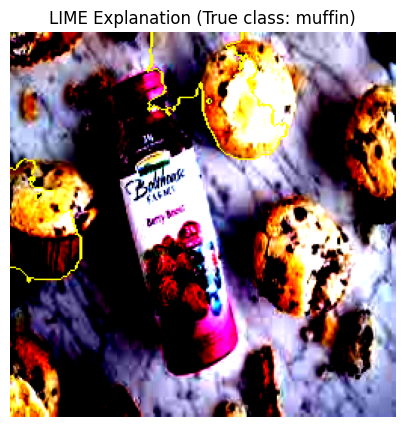

In [26]:
test_image, true_label, idx = get_test_image()
test_image_cpu = test_image.cpu()

lime_exp = lime_explanation(test_image_cpu, model.to('cpu'))

plt.figure(figsize=(10, 5))
temp, mask = lime_exp.get_image_and_mask(
    lime_exp.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=False
)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f'LIME Explanation (True class: {test_ds.classes[true_label]})')
plt.axis('off')
plt.show()

### Вывод
В ходе выполнения курсовой работы была дообучена предобученная нейронная сеть, чтобы она смогла с высокой точностью определять на изображениях чихуахуа и кексы. Также в ходе выполнения был применен алгоритм LIME, чтобы выделить те признаки, которые влияют на классификацию. Алгоритм выделяет форму чихуахуа, глаза, форму морды и нос. В случае с кексами алгоритм выделяет форму кексов.